# 将tfkeras转化为estimator--titanic问题

In [1]:
# 导入
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## titanic生存预测问题
哪些乘客获救，哪些没有
### 数据集探索

In [2]:
# 下载数据集
train_file = 'data/titanic/train.csv'
eval_file = 'data/titanic/eval.csv'

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())
print(eval_df.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [3]:
# 将survived字段取出，赋给label
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [4]:
# 查看train中的统计量
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
# 查看shape大小
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


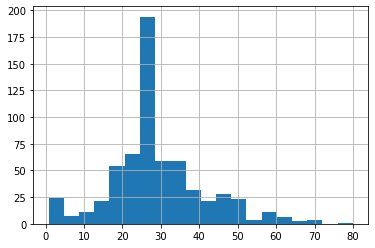

In [6]:
# 查看年龄分布，用直方图展示
train_df.age.hist(bins=20)

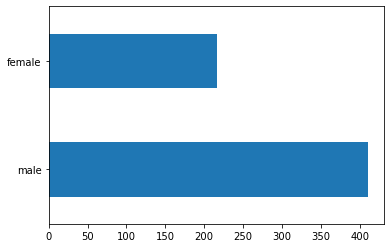

In [7]:
# 查看性别统计，用横向柱状图表示
train_df.sex.value_counts().plot(kind = 'barh')

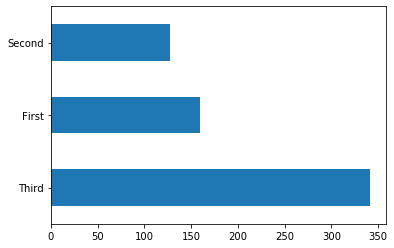

In [8]:
# 查看不同舱位统计，用横向柱状图表示
train_df['class'].value_counts().plot(kind = 'barh')

sex
female    0.778802
male      0.180488
Name: survived, dtype: float64


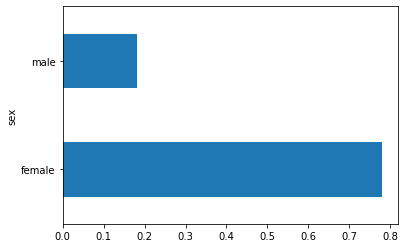

In [9]:
# 统计男性获救占比和女性获救占比
print(pd.concat([train_df, y_train], axis=1).groupby('sex').survived.mean())
pd.concat([train_df, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh')

### feature_column 做特征工程
feature_column对列数据进行封装，如果列数据是离散值，方便做onehot编码，变成向量，如果列数据是连续值，可以直接输入给模型，也可以对数据进行分桶变成离散值，再做onehot编码

In [10]:
# 将数据分成两类：离散和连续
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                       'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []
for categorical_column in categorical_columns:
    # 获取离散值所有可能值
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    # 对离散值封装，做onehot编码，再加入feature_columns中
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))
    
for numeric_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(numeric_column, dtype=tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [11]:
# 把dataframe变成字典
dict(train_df)

{'sex': 0        male
 1      female
 2      female
 3      female
 4        male
         ...  
 622      male
 623      male
 624    female
 625    female
 626      male
 Name: sex, Length: 627, dtype: object, 'age': 0      22.0
 1      38.0
 2      26.0
 3      35.0
 4      28.0
        ... 
 622    28.0
 623    25.0
 624    19.0
 625    28.0
 626    32.0
 Name: age, Length: 627, dtype: float64, 'n_siblings_spouses': 0      1
 1      1
 2      0
 3      1
 4      0
       ..
 622    0
 623    0
 624    0
 625    1
 626    0
 Name: n_siblings_spouses, Length: 627, dtype: int64, 'parch': 0      0
 1      0
 2      0
 3      0
 4      0
       ..
 622    0
 623    0
 624    0
 625    2
 626    0
 Name: parch, Length: 627, dtype: int64, 'fare': 0       7.2500
 1      71.2833
 2       7.9250
 3      53.1000
 4       8.4583
         ...   
 622    10.5000
 623     7.0500
 624    30.0000
 625    23.4500
 626     7.7500
 Name: fare, Length: 627, dtype: float64, 'class': 0       Third
 1    

In [12]:
# 从pandas dataframe中构建dataset
def make_dataset(data_df, label_df, epochs = 10, shuffle = True, batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [13]:
# test
train_dataset = make_dataset(train_df, y_train, batch_size=5)
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: id=38, shape=(5,), dtype=string, numpy=array([b'male', b'female', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: id=30, shape=(5,), dtype=float64, numpy=array([32., 28., 31., 28., 28.])>, 'n_siblings_spouses': <tf.Tensor: id=36, shape=(5,), dtype=int32, numpy=array([0, 3, 0, 0, 0])>, 'parch': <tf.Tensor: id=37, shape=(5,), dtype=int32, numpy=array([0, 1, 0, 0, 0])>, 'fare': <tf.Tensor: id=35, shape=(5,), dtype=float64, numpy=array([ 7.8542, 25.4667, 13.    ,  7.75  , 26.    ])>, 'class': <tf.Tensor: id=32, shape=(5,), dtype=string, numpy=array([b'Third', b'Third', b'Second', b'Third', b'First'], dtype=object)>, 'deck': <tf.Tensor: id=33, shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'unknown', b'unknown', b'A'], dtype=object)>, 'embark_town': <tf.Tensor: id=34, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Queenstown',
       b'Southampton'], dtype=object)>, 'alone': <tf.Tensor: id=31, sha

将 feature_columns 应用到 dataset上

feature_columns 是对feature变化的一组规则，keras.layers.DenseFeatures可以将每一个规则应用到dataset上去

In [14]:
# keras.layers.DenseFeatures test
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[18.]
 [31.]
 [28.]
 [28.]
 [31.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

In [15]:
# 将feature_columns 全部应用
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[21.      0.      1.      0.      1.      0.      0.      0.      0.
   0.      0.      1.      0.      0.      1.      0.      0.      0.
  77.9583  0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      0.      1.    ]
 [25.      1.      0.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
  17.8     1.      0.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.

### keras建模

In [16]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.01),
              metrics=['accuracy'])

model 训练有两种方式：
1. model.fit
2. model -> estimator -> train

In [17]:
train_dataset = make_dataset(train_df, y_train, epochs=100)
eval_dataset = make_dataset(eval_df, y_eval, epochs=1, shuffle=False)

# 1. model.fit
history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                    steps_per_epoch = 18,
                    validation_steps = 8,
                    epochs = 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train for 18 steps, validate for 8 steps
Epoch 1/100
18/18 [==============================] - 2s 96ms/step - loss: 2.5666 - accuracy: 0.5885 - val_loss: 0.9956 - val_accuracy: 0.5391
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.6496 - accuracy: 0.6927 - val_loss: 0.5810 - val_accuracy: 0.6797
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.6007 - accuracy: 0.6962 - val_loss: 0.5490 - val_accuracy: 0.7305
Epoch 4/100
18/18 [======================

keras.estimator.model_to_estimator 将model转化为 estimator

estimator.train进行训练

所需要的参数：input_fn
- function
- return a. (features, label) b. dataset -> (feature, label)

In [18]:
# 2. model -> estimator -> train
# 将model转化为estimator
estimator = keras.estimator.model_to_estimator(model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Awebone\\AppData\\Local\\Temp\\tmpfp_y23zg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000016B4AB1A6A0>, '_task_type': 'worker', '_task_id': 0, '_glo

In [19]:
# bug 未修复
estimator.train(input_fn = lambda : make_dataset(train_df, y_train, epochs=100))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.


ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.